In [ ]:
# default_exp think_bays_light_bulbs

# think_bays_light_bulbs

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import numpy as np
import pandas as pd
from utils import make_uniform, make_joint, normalize, decorate

In [ ]:
%matplotlib inline
from scipy.stats import weibull_min

def weibull_dist(lam, k):
    return weibull_min(k, scale=lam)

### Load data

In [ ]:
df = pd.read_csv("data/lamps.csv", index_col=0)
df.shape

(33, 3)

In [ ]:
# h: the times when bulbs failed
# f: the number of bulbs failed
# K: 
df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


In [ ]:
df.h.mean(), df.h.std()

(1363.6363636363637, 452.4415582551669)

### Pmf

In [ ]:
df['f'].to_numpy()

array([0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 5, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3,
       1, 1, 2, 2, 5, 1, 1, 1, 1, 1, 1])

In [ ]:
from empiricaldist import Pmf

pmf_bulb = Pmf(df['f'].to_numpy(), df['h'])
pmf_bulb.normalize()

50

### Asumption with Weibull distribution

In [ ]:
# Uniform priors for λ and k
lams = np.linspace(1000, 2000, num=51)
prior_lam = make_uniform(lams, name="lambda")

ks = np.linspace(1, 10, num=51)
prior_k = make_uniform(ks, name="k")

prior_bulb = make_joint(prior_lam, prior_k)


In [ ]:
# data
data_bulb = np.repeat(df['h'], df['f'])
len(data_bulb)

50

### Posterior distribution

In [ ]:
def update_weibull(prior, data):
    """Update the prior based on data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    
    densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)
    
    return posterior

In [ ]:
# Calculate posterior dist
posterior_bulb = update_weibull(prior_bulb, data_bulb)

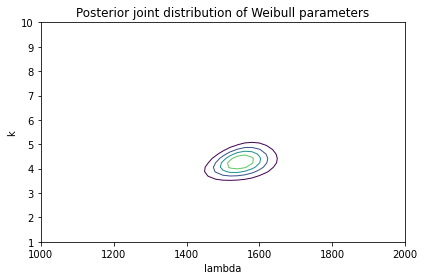

In [ ]:
from utils import plot_contour

plot_contour(posterior_bulb)
decorate(title='Posterior joint distribution of Weibull parameters')

### Posterior means

In [ ]:
# Make a mesh that contains the values of λ and k
lam_mesh, k_mesh = np.meshgrid(prior_bulb.columns, prior_bulb.index)

# Use weibull_dist to compute the mean
means = weibull_dist(lam_mesh, k_mesh).mean()
means.shape

(51, 51)

In [ ]:
prod = means * posterior_bulb
prod.to_numpy().sum()

1412.7242774305005

In [ ]:
def joint_weibull_mean(joint):
    """Compute the mean of a joint distribution of Weibulls."""
    lam_mesh, k_mesh = np.meshgrid(
        joint.columns, joint.index)
    means = weibull_dist(lam_mesh, k_mesh).mean()
    prod = means * joint
    return prod.to_numpy().sum()